In [6]:
# === IMPORTACIONES ===
import os
import shutil
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

#Cosas a hacer

#Ajustar largos a la fibra anterior de forma correcta


In [7]:
import math

alpha = 0.95
betha = 0.95
gamma = 0.05

fps = 200
delta_t = 1 / fps

# --------------------------------------------------------------------------------
# 1) Funciones auxiliares para manejar el ángulo
# --------------------------------------------------------------------------------

def normalizar_diferencia_angular(angulo_medido, angulo_filtrado):
    """
    Devuelve la diferencia angular 'pequeña' entre [-180, 180],
    es decir, corrige saltos de 179 -> -179 o viceversa.
    """
    diff = angulo_medido - angulo_filtrado
    while diff > 180:
        diff -= 360
    while diff <= -180:
        diff += 360
    return diff

def normalizar_angulo(angulo):
    """
    Asegura que 'angulo' quede dentro de [-180, 180].
    """
    while angulo > 180:
        angulo -= 360
    while angulo <= -180:
        angulo += 360
    return angulo

# --------------------------------------------------------------------------------
# 2) Versión genérica de las funciones alpha, beta, gamma (para posición lineal)
# --------------------------------------------------------------------------------

def filtro_alpha(x, x_i, z, t):
    # x  = valor actual del filtro
    # x_i = valor filtrado anterior
    # z  = medición (detección actual)
    x_f = x + alpha * (z - x_i)
    return x_f

def filtro_betha(x, x_i, z, t):
    # Beta corrige la velocidad
    x_f = x + betha * ((z - x_i) / t)
    return x_f

def filtro_gamma(x, x_i, z, t):
    # Gamma corrige la aceleración
    x_f = x + gamma * ((z - x_i) / (t**2) * 2)
    return x_f

# --------------------------------------------------------------------------------
# 3) Versión específica de alpha, beta, gamma PARA ÁNGULO
#    - Se normalizan las diferencias de ángulo para evitar saltos bruscos
# --------------------------------------------------------------------------------

def filtro_alpha_angulo(angulo_filtrado, angulo_medido):
    diff_ang = normalizar_diferencia_angular(angulo_medido, angulo_filtrado)
    angulo_f = angulo_filtrado + alpha * diff_ang
    # Aseguramos que el resultado final esté en [-180, 180]
    angulo_f = normalizar_angulo(angulo_f)
    return angulo_f

def filtro_betha_angulo(omega_filtrado, angulo_filtrado, angulo_medido, t):
    """
    Ajusta la velocidad angular (omega) en función de la diferencia angular.
    """
    diff_ang = normalizar_diferencia_angular(angulo_medido, angulo_filtrado)
    # Beta corrige la 'velocidad angular' asumiendo que diff_ang / t ≈ delta de ángulo / tiempo
    omega_f = omega_filtrado + betha * (diff_ang / t)
    return omega_f

def filtro_gamma_angulo(aceleracion_angular_filtrada, angulo_filtrado, angulo_medido, t):
    """
    Ajusta la aceleración angular en función de la diferencia angular.
    """
    diff_ang = normalizar_diferencia_angular(angulo_medido, angulo_filtrado)
    # Gamma corrige la 'aceleración angular'
    # Observa el factor (diff_ang / (t^2) * 0.5), igual que la parte lineal.
    a_ang_f = aceleracion_angular_filtrada + gamma * ((diff_ang) / (t**2) * 0.5)
    return a_ang_f

# --------------------------------------------------------------------------------
# 4) Filtro "Kalman" (en realidad, alpha-beta-gamma) para posición XY y ÁNGULO
# --------------------------------------------------------------------------------

def filtro_kalman(parametros_kalman, deteccion_actual, salto_temporal=1):
    """
    parámetros_kalman = [
       [xx,   xy],             # 0
       [vx,   vy],             # 1
       [ax,   ay],             # 2
       [angulo],               # 3
       [omega],                # 4
       [aceleracion_angular],  # 5
       [largo]                 # 6 (solo se conserva, no se corrige con alpha/beta/gamma)
    ]

    deteccion_actual = [
       [zxx, zxy],      # 0 -> posición medida
       [z_angulo],      # 1 -> ángulo medido
       [z_largo]        # 2 -> largo (opcional, no se corrige)
    ]

    salto_temporal = cuántos frames saltas en la secuencia (por defecto 1)
    """
    t = delta_t * salto_temporal

    # --- Despliegue de datos de entrada ---
    # Posición
    xx_i = parametros_kalman[0][0]
    xy_i = parametros_kalman[0][1]

    # Velocidad
    vx_i = parametros_kalman[1][0]
    vy_i = parametros_kalman[1][1]

    # Aceleración
    ax_i = parametros_kalman[2][0]
    ay_i = parametros_kalman[2][1]

    # Ángulo
    angulo_i = parametros_kalman[3][0]

    # Velocidad angular
    omega_i = parametros_kalman[4][0]

    # Aceleración angular
    aceleracion_angular_i = parametros_kalman[5][0]

    # Largo
    largo = parametros_kalman[6][0]

    # --- Detecciones actuales ---
    zxx = deteccion_actual[0][0]
    zxy = deteccion_actual[0][1]

    z_angulo = deteccion_actual[1][0]
    z_largo  = deteccion_actual[2][0]  # se mantiene, si lo necesitas actualizar, lo puedes manejar igual

    # --- Fase de corrección (alpha, beta, gamma) ---
    # Posición
    xx_f = filtro_alpha(xx_i, xx_i, zxx, t)
    xy_f = filtro_alpha(xy_i, xy_i, zxy, t)

    # Velocidad
    vx_f = filtro_betha(vx_i, xx_i, zxx, t)
    vy_f = filtro_betha(vy_i, xy_i, zxy, t)

    # Aceleración
    ax_f = filtro_gamma(ax_i, xx_i, zxx, t)
    ay_f = filtro_gamma(ay_i, xy_i, zxy, t)

    # Ángulo
    angulo_f = filtro_alpha_angulo(angulo_i, z_angulo)

    # Velocidad angular
    omega_f = filtro_betha_angulo(omega_i, angulo_i, z_angulo, t)

    # Aceleración angular
    aceleracion_angular_f = filtro_gamma_angulo(aceleracion_angular_i, angulo_i, z_angulo, t)

    # --- Fase de predicción (aplicamos la cinemática con lo filtrado) ---
    # Posición final
    xx_ff = xx_f + vx_f * t + 0.5 * ax_f * (t**2)
    xy_ff = xy_f + vy_f * t + 0.5 * ay_f * (t**2)

    vx_ff = vx_f + ax_f * t
    vy_ff = vy_f + ay_f * t

    ax_ff = ax_f
    ay_ff = ay_f

    # Ángulo final
    angulo_ff = angulo_f + omega_f * t + 0.5 * aceleracion_angular_f * (t**2)
    # Normalizamos el resultado final
    angulo_ff = normalizar_angulo(angulo_ff)

    omega_ff = omega_f + aceleracion_angular_f * t
    aceleracion_angular_ff = aceleracion_angular_f

    # Mantén el largo como estaba o actualízalo si lo deseas
    # largo_ff = filtro_alpha(largo, largo, z_largo, t)  # (Opcional)
    largo_ff = z_largo

    # --- Actualizamos el vector de parámetros Kalman ---
    parametros_kalman = [
        [xx_ff, xy_ff],
        [vx_ff, vy_ff],
        [ax_ff, ay_ff],
        [angulo_ff],
        [omega_ff],
        [aceleracion_angular_ff],
        [largo_ff]
    ]

    return parametros_kalman

# --------------------------------------------------------------------------------
# 5) Conjetura inicial
# --------------------------------------------------------------------------------

def conjetura_inicial(parametros_kalman):
    """
    Reajusta los valores iniciales. 
    Puede usarse cuando creas por primera vez los parámetros de la fibra,
    o cada vez que necesites 'resetear' el estado.
    """
    xx_f = parametros_kalman[0][0]
    xy_f = parametros_kalman[0][1]

    # Iniciamos velocidades y aceleraciones a 0
    vx_f = 0
    vy_f = 0
    ax_f = 0
    ay_f = 0

    # El ángulo inicial lo tomamos de la 2da posición [1][0] (en tu ejemplo original),
    # pero ajusta según cómo guardes el dato en 'parametros_kalman'.
    angulo_f = parametros_kalman[1][0]  
    omega_f = 0
    aceleracion_angular_f = 0

    # Si el largo está en la 3ra posición [2][0], lo obtenemos ahí
    largo = parametros_kalman[2][0]

    # Realizamos el paso predictivo con delta_t
    xx_ff = xx_f + vx_f * delta_t + 0.5 * ax_f * (delta_t**2)
    xy_ff = xy_f + vy_f * delta_t + 0.5 * ay_f * (delta_t**2)

    vx_ff = vx_f + ax_f * delta_t
    vy_ff = vy_f + ay_f * delta_t

    ax_ff = ax_f
    ay_ff = ay_f

    angulo_ff = angulo_f + omega_f * delta_t + 0.5 * aceleracion_angular_f * (delta_t**2)
    # Normalizamos por si acaso
    angulo_ff = normalizar_angulo(angulo_ff)

    omega_ff = omega_f + aceleracion_angular_f * delta_t
    aceleracion_angular_ff = aceleracion_angular_f

    # Guardamos en parámetros Kalman
    parametros_kalman = [
        [xx_ff, xy_ff],      # Nueva posición
        [vx_ff, vy_ff],      # Nueva velocidad
        [ax_ff, ay_ff],      # Nueva aceleración
        [angulo_ff],         # Ángulo
        [omega_ff],          # Velocidad angular
        [aceleracion_angular_ff],  # Aceleración angular
        [largo]              # Largo
    ]
    return parametros_kalman


In [8]:
# === FUNCIONES AUXILIARES ===
def obtener_carpeta_predict_mas_grande(ruta_base):
    """
    Encuentra la carpeta 'predict' con el número más alto en la ruta_base.
    Si no existe, retorna 'predict'.
    Si existe 'predict', 'predict1', 'predict2', ... 
    retorna la siguiente carpeta 'predictN+1'.
    """
    carpetas = [f for f in os.listdir(ruta_base) 
                if f.startswith('predict') and os.path.isdir(os.path.join(ruta_base, f))]
    numeros = []
    for carpeta in carpetas:
        try:
            num = int(carpeta.replace('predict', '')) if carpeta != 'predict' else 0
            numeros.append((num, carpeta))
        except ValueError:
            continue
    numeros.sort(reverse=True)
    if numeros:
        return os.path.join(ruta_base, f"predict{numeros[0][0] + 1}")
    else:
        return os.path.join(ruta_base, 'predict')


def convertir_a_json_compatible(obj):
    """
    Convierte tipos de datos no serializables por JSON a tipos nativos de Python.
    """
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Tipo de dato no serializable: {type(obj)}")

In [9]:
# === FUNCXIONES YOLO ===

def cargar_modelo ():
    # Determina la carpeta 'predictN' donde se guardarán resultados.
    ruta_procesadas = obtener_carpeta_predict_mas_grande(ruta_base)
    print(f"Usando la carpeta de resultados: {ruta_procesadas}")
    
    # Carga el modelo YOLO con los pesos entrenados
    model = YOLO(ruta_pesos)
    
    # Obtiene la lista de imágenes a procesar
    imagenes = [os.path.join(carpeta_imagenes, img) for img in os.listdir(carpeta_imagenes) 
                if img.lower().endswith(('.jpg', '.png', '.bmp'))]
    imagenes = sorted(imagenes)[:numero_imagenes]

    return model, ruta_procesadas , imagenes

# Predicción con YOLO en la imagen actual
def generar_prediccion (idx, imagen, ruta_procesadas):
    results = model.predict(
        source=imagen, conf=0.25, save=True, save_dir=ruta_procesadas, hide_labels=True, line_thickness=1
    )

    # Si no se detectan objetos, continuar con la siguiente imagen
    if not results[0].boxes:
        print(f"No se detectaron objetos en la imagen {imagen}")
        return None, None, None, None, None

    # Extraer información de las detecciones de YOLO
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()

    # Calcular centroides, largo máximo y ángulo para cada detección
    centroids, max_lengths, angles = [], [], []
    for box in boxes:
        x1, y1, x2, y2 = box
        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0
        width = x2 - x1
        height = y2 - y1
        max_length = max(width, height)

        #Se calcula el angulo segun cada fibra, no respecto a un origen
        angle = np.degrees(np.arctan2(height, width))

        #if angle > 0 and angle < 90:
            #angle = 180 - angle

        centroids.append((cx, cy))
        max_lengths.append(max_length)
        angles.append(angle)

    return centroids, angles, max_lengths, scores, boxes

def guardar_imagen ():
    """
    Guarda en disco la imagen procesada, dibujando la fibra Kalman (líneas) e IDs.
    
    Parámetros:
    -----------
    ruta_procesada : str
        Directorio donde se guardan las imágenes procesadas.
    ruta_imagen_original : str
        Ruta a la imagen original. Se usará su basename para construir 'processed_image_path'.
    dictionary : dict
        Diccionario que contiene la información de cada fibra (Kalman, etc.).
    fiber_ids_for_current_frame : dict
        Mapa i -> fiber_id_str (IDs de cada fibra para este frame).
    boxes : list or np.array
        Coordenadas de bounding boxes. Se asume boxes[i] = [x1, y1, x2, y2].
    variacion_x : int, opcional
        Desplazamiento en X para dibujar el rectángulo de referencia.
    variacion_y : int, opcional
        Desplazamiento en Y para dibujar el rectángulo de referencia.
    """

    # Construir la ruta de la imagen "ya procesada" por YOLO
    processed_image_path = os.path.join(ruta_procesada, os.path.basename(imagen))
    
    # Verificar si existe la imagen
    if not os.path.exists(processed_image_path):
        print(f"[ADVERTENCIA] No se encontró la imagen procesada en: {processed_image_path}")
        return  # Salir de la función
    
    # Cargar la imagen (BGR por defecto en OpenCV)
    processed_image = cv2.imread(processed_image_path)
    if processed_image is None:
        print(f"[ADVERTENCIA] Error al leer la imagen en: {processed_image_path}")
        return
    
    # Si deseas dibujar en RGB (por compatibilidad con matplotlib):
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
    
    # Recorrer las fibras detectadas
    for i, fiber_id_str in fiber_ids_for_current_frame.items():
        # 1) Obtener la última información de Kalman asociada a la fibra
        fibra_predecida = dictionary[fiber_id_str]["kalman"][-1]
        
        # Por convención del ejemplo:
        kalman_pos = fibra_predecida[0]  # [xx, xy]
        kalman_largo = fibra_predecida[6][0]  # [largo]
        kalman_angulo = fibra_predecida[3][0]  # [angulo]

        
        
        # 2) Calcular extremos de la fibra usando ángulo y largo
        kalman_angle_rad = np.radians(kalman_angulo)
        delta_x = (kalman_largo / 2) * np.cos(kalman_angle_rad)
        delta_y = (kalman_largo / 2) * np.sin(kalman_angle_rad)
        
        kalman_x1 = int(kalman_pos[0] - delta_x)
        kalman_y1 = int(kalman_pos[1] - delta_y)
        kalman_x2 = int(kalman_pos[0] + delta_x)
        kalman_y2 = int(kalman_pos[1] + delta_y)
        
        # 3) Dibujar la fibra Kalman (en amarillo, grosor 2)
        #cv2.line(
        #    processed_image,
        #    (kalman_x1, kalman_y1),
        #    (kalman_x2, kalman_y2),
        #    (255, 255, 0),  # Amarillo (en RGB)
        #    2
        #)
        
        # 4) Dibujar el ID de la fibra cerca del bounding box
        x1, y1, x2, y2 = boxes[i]  # boxes[i] => [x1, y1, x2, y2]
        
        cv2.putText(
            processed_image,
            fiber_id_str,
            (int(x1), int(y1) - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),  # Azul (en RGB)
            2
        )
    
    # 5) Dibujar un rectángulo de referencia en la esquina superior derecha
    h, w, _ = processed_image.shape
    
    rect_x1 = w - variacion_x - 10
    rect_y1 = 10
    rect_x2 = w - 10
    rect_y2 = 10 + variacion_y
    
    cv2.rectangle(
        processed_image,
        (rect_x1, rect_y1),
        (rect_x2, rect_y2),
        (0, 255, 0),  # Verde (en RGB)
        2
    )
    
    # 6) Convertir de vuelta a BGR para guardar con OpenCV
    processed_image_bgr = cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR)
    
    # 7) Guardar la imagen con anotaciones
    cv2.imwrite(processed_image_path, processed_image_bgr)
    
    # 8) (Opcional) Mostrar la imagen (descomentar para debug)
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(4, 4))
    # plt.imshow(processed_image)  # imagen ya en RGB
    # plt.title(f'Imagen Procesada: {os.path.basename(ruta_imagen_original)}')
    # plt.axis('off')
    # plt.tight_layout()
    # plt.show()
    

In [ ]:
#Obtengo la ruta del directorio
base = os.getcwd()

# === CONFIGURACIÓN DE RUTAS Y PARÁMETROS ===
#carpeta_imagenes = os.path.join(base, 'runs', 'Fotos')
carpeta_imagenes = os.path.join(os.path.dirname(base), 'Dataset', 'Toma2')
ruta_pesos = os.path.join(base, 'Yolo-Model', 'best.pt') # Pesos del modelo YOLO entrenado
ruta_base = os.path.join(base, 'runs', 'segment')  # Ruta base donde se crean las carpetas 'predictN'
numero_imagenes = 2000      # Número de imágenes a procesar

# Límites de variación para reconocer la misma fibra entre fotogramas
variacion_x = 10
variacion_y = 10
variacion_largo = 40
variacion_angulo = 5

# === LÓGICA PRINCIPAL ===

model, ruta_procesada, imagenes = cargar_modelo()

# Diccionario para almacenar la información de las fibras detectadas
dictionary = {}
current_fiber_id = 0  # ID global para asignar nuevas fibras
fibras_imagen_actual = []  # Lista de fibras detectadas en el fotograma actual

fibras_detectadas_imagen = []

# Procesa cada imagen
for idx, imagen in enumerate(imagenes):
    print("==========================")
    print(f"\nProcesando imagen {idx + 1}")

    centroids, angles, max_lengths, scores, boxes = generar_prediccion (idx, imagen, ruta_procesada)

    #Guardo la cantidad de fibras detectadas
    fibras_detectadas_imagen.append(len(scores))

    # Mantener referencia de las fibras detectadas en la imagen anterior
    fibras_imagen_anterior = fibras_imagen_actual
    # Reiniciar la lista de fibras para esta imagen
    fibras_imagen_actual = []
    

    #Si no se detecta nada en la imagen, simplemente continuo
    if centroids == None:
        continue

    # Diccionario temporal para asignar ID de fibra a cada detección del frame actual
    fiber_ids_for_current_frame = {}

    # Si es la primera imagen, todas las fibras son nuevas
    if idx == 0:
        for i in range(len(scores)):
            current_fiber_id += 1
            fiber_id_str = str(current_fiber_id)
            # Inicializa la entrada en el diccionario con los datos de la detección
            parametros_kalman = conjetura_inicial([[centroids[i][0], centroids[i][1]],[angles[i]],[max_lengths[i]]])
            dictionary[fiber_id_str] = {
                "centroide": [[centroids[i][0], centroids[i][1]]],
                "largo_maximo": [[max_lengths[i]]],
                "angulo": [[angles[i]]],
                "frame": [[idx+1]],
                "kalman": [parametros_kalman]
            }
            fiber_ids_for_current_frame[i] = fiber_id_str
            fibras_imagen_actual.append(fiber_id_str)

    else:

        for i in range(len(scores)):
            found_match = False

            for index in fibras_imagen_anterior:

                #Si ya encontro una fibra, detiene el ciclo
                if found_match:
                    break

                #Obtengo la imagen proyectada anteiormente
                parametros_kalman = dictionary[index]["kalman"][-1]

                #En este caso segun la informacion que detecto de la fibra es toy generando una prediccion de su movimiento
                #Le otorgo un bajo peso a la deteccion actual
                deteccion_actual = [[centroids[i][0], centroids[i][1]],[angles[i]],[max_lengths[i]]]
                #Genero la prediccion
                prediccion = filtro_kalman(parametros_kalman, deteccion_actual, 1)
                

                delta_x = abs(prediccion[0][0] - centroids[i][0])
                delta_y = abs(prediccion[0][1] - centroids[i][1])

                # Verificar si la posición es consistente
                if delta_x < variacion_x and delta_y < variacion_y:      

                    delta_largo = abs(prediccion[6][0] - max_lengths[i])
                    delta_angulo = abs(prediccion[3][0] - angles[i])


                    # Verificar si el largo y el ángulo también son consistentes
                    if delta_angulo < variacion_angulo:

                        #Si ya hice una relacion anterior de la fibra, no hago un match
                        if index in fibras_imagen_actual:
                            #break
                            continue

                        #Genero la prediccion
                        #De esta manera guardo en el diccionario dende deberia estar la siguiente fibre
                        
                        # Es la misma fibra
                        dictionary[index]["centroide"].append([centroids[i][0], centroids[i][1]])
                        dictionary[index]["largo_maximo"].append([max_lengths[i]])
                        dictionary[index]["angulo"].append([angles[i]])
                        dictionary[index]["frame"].append([idx+1])
                        dictionary[index]["kalman"].append(prediccion)
                        fiber_ids_for_current_frame[i] = index
                        found_match = True
                        fibras_imagen_actual.append(index)
                        break

            # Si no se encontró coincidencia ni en el frame anterior ni dos frames atrás, es una nueva fibra
            if not found_match:
                current_fiber_id += 1
                fiber_id_str = str(current_fiber_id)
                parametros_kalman = conjetura_inicial([[centroids[i][0], centroids[i][1]],[angles[i]],[max_lengths[i]]])
                dictionary[fiber_id_str] = {
                    "centroide": [[centroids[i][0], centroids[i][1]]],
                    "largo_maximo": [[max_lengths[i]]],
                    "angulo": [[angles[i]]],
                    "frame": [[idx+1]],
                    "kalman": [parametros_kalman]
                }
                fiber_ids_for_current_frame[i] = fiber_id_str
                fibras_imagen_actual.append(fiber_id_str)
       
    #Guardo la imagen con las anotaciones
    guardar_imagen ()

# Agregar la ruta de resultados al diccionario final
dictionary["ruta"] = ruta_procesada

dictionary["fibras_por_frame"] = fibras_detectadas_imagen

# Guardar el diccionario con todos los datos de las fibras en un archivo JSON
with open("fibras.json", "w") as file:
    json.dump(dictionary, file, indent=4, default=convertir_a_json_compatible)

print("Diccionario guardado en fibras.json")

Usando la carpeta de resultados: C:\Users\MBX\Desktop\Investigacion\Particle-Tracking-Velocimetry-Improving-Via-Deep-Learning\Particle-Tracking-Velocimetry\YOLO\runs\segment\predict1

Procesando imagen 1
WARNING  'hide_labels' is deprecated and will be removed in in the future. Use 'show_labels' instead.
WARNING  'line_thickness' is deprecated and will be removed in in the future. Use 'line_width' instead.

image 1/1 C:\Users\MBX\Desktop\Investigacion\Particle-Tracking-Velocimetry-Improving-Via-Deep-Learning\Particle-Tracking-Velocimetry\Dataset\Toma2\Basler_acA1440-220uc__40343408__20250108_121135810_0000.bmp: 1024x1024 20 Fibers, 11.3ms
Speed: 3.3ms preprocess, 11.3ms inference, 55.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict2
[ADVERTENCIA] No se encontró la imagen procesada en: C:\Users\MBX\Desktop\Investigacion\Particle-Tracking-Velocimetry-Improving-Via-Deep-Learning\Particle-Tracking-Velocimetry\YOLO\runs\segment\predict1\Basler_acA1

In [10]:
#Obtengo la ruta del directorio
base = os.getcwd()

import json

def filtrar_por_minimo_frames(json_data, min_frames):
    # Diccionario donde guardaremos las fibras que cumplan la condición
    filtrado = {}

    # Si deseas conservar claves generales como 'ruta' o 'fibras_por_frame', puedes copiarlas:
    if 'ruta' in json_data:
        filtrado['ruta'] = json_data['ruta']
    if 'fibras_por_frame' in json_data:
        filtrado['fibras_por_frame'] = json_data['fibras_por_frame']

    # Recorremos todas las "fibras" (claves tipo "1", "2", etc.)
    for fibra_id, fibra_data in json_data.items():
        # Evitamos procesar las claves especiales que ya copiamos
        if fibra_id in ['ruta', 'fibras_por_frame']:
            continue
        
        # Verificamos que exista la clave 'frame' en los datos de la fibra
        if 'frame' in fibra_data:
            # La cantidad de frames en que aparece la fibra es la longitud de este array
            num_frames = len(fibra_data['frame'])
            
            # Si la cantidad de frames es >= min_frames, guardamos la fibra en el filtrado
            if num_frames >= min_frames:
                filtrado[fibra_id] = fibra_data
    
    return filtrado

# Ejemplo de uso:
if __name__ == "__main__":
    # 1. Carga el JSON original
    archivo_fibras = os.path.join(base,"fibras.json")
    archivo_fibras_filtrado = os.path.join(base,"fibras_filtradas.json")
    with open(archivo_fibras, "r", encoding="utf-8") as f:
        datos_originales = json.load(f)
    
    # 2. Filtra los datos, conservando solo aquellos con >= 5 frames
    min_frames = 20
    datos_filtrados = filtrar_por_minimo_frames(datos_originales, min_frames)
    
    # 3. Guarda el resultado en un nuevo archivo JSON
    with open(archivo_fibras_filtrado, "w", encoding="utf-8") as f:
        json.dump(datos_filtrados, f, indent=4, ensure_ascii=False)

    print(f"Se han filtrado los datos. Solo se conservan fibras con al menos {min_frames} frames.")


Se han filtrado los datos. Solo se conservan fibras con al menos 20 frames.


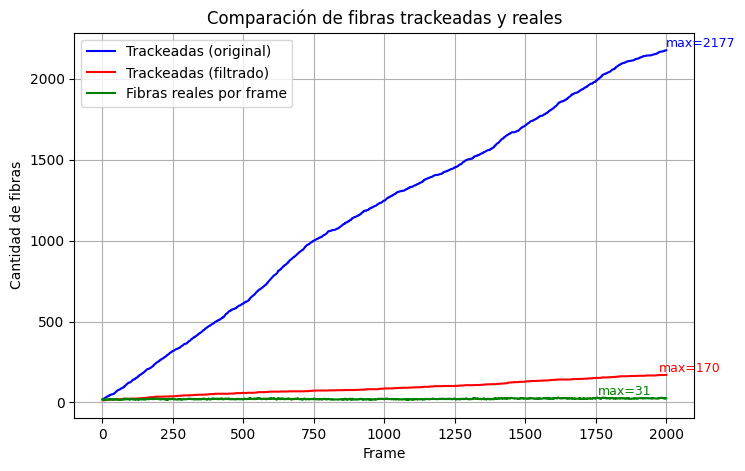

In [11]:
import json
import matplotlib.pyplot as plt

def compute_fibers_tracked_by_frame(datos):
    """
    Dado un diccionario (contenido de un JSON),
    retorna (frames_eje_x, fibras_acumuladas_eje_y), donde:
      - frames_eje_x = [1, 2, ..., max_frame_en_datos]
      - fibras_acumuladas_eje_y[i] = cuántas fibras
        han aparecido en frame <= frames_eje_x[i]
    """
    fibra_min_frame = {}
    max_frame_global = 0

    for key, value in datos.items():
        # Saltamos claves especiales
        if key in ("ruta", "fibras_por_frame"):
            continue

        lista_frames = value.get("frame", [])
        if not lista_frames:
            continue

        # frames como [ [1],[2],...], los convertimos a [1,2,...]
        frames_planos = [f[0] for f in lista_frames]
        min_fr = min(frames_planos)
        fibra_min_frame[key] = min_fr
        max_frame_global = max(max_frame_global, max(frames_planos))

    frames_eje_x = []
    fibras_acumuladas_eje_y = []

    for f in range(1, max_frame_global + 1):
        # Contamos cuántas fibras aparecen por primera vez en un frame <= f
        count = sum(1 for fr in fibra_min_frame.values() if fr <= f)
        frames_eje_x.append(f)
        fibras_acumuladas_eje_y.append(count)

    return frames_eje_x, fibras_acumuladas_eje_y


def plot_comparacion_tres_curvas(datos_original, datos_filtrado):
    """
    Genera una gráfica con:
      1) Fibras trackeadas acumuladas del JSON original.
      2) Fibras trackeadas acumuladas del JSON filtrado.
      3) Cantidad de fibras real por frame (usando 'fibras_por_frame').
    Anotando el valor máximo de cada curva en el gráfico.
    """
    # --- Curva 1: JSON original (fibras trackeadas acumuladas)
    x_orig, y_orig = compute_fibers_tracked_by_frame(datos_original)

    # --- Curva 2: JSON filtrado
    x_filt, y_filt = compute_fibers_tracked_by_frame(datos_filtrado)

    # --- Curva 3: "fibras_por_frame" real (por frame)
    x_real, y_real = [], []
    if "fibras_por_frame" in datos_original:
        lista_real = datos_original["fibras_por_frame"]
        x_real = list(range(1, len(lista_real) + 1))
        y_real = lista_real

    plt.figure(figsize=(8, 5))

    # 1) Trackeadas original
    plt.plot(x_orig, y_orig, color='blue', label='Trackeadas (original)')
    # Anotar el valor máximo si y_orig no está vacío
    if y_orig:
        max_val_orig = max(y_orig)
        idx_orig = y_orig.index(max_val_orig)
        x_pos_orig = x_orig[idx_orig]
        # Agregamos texto cerca del punto máximo
        plt.text(x_pos_orig, max_val_orig,
                 f"max={max_val_orig}",
                 color='blue',
                 ha='left', va='bottom', fontsize=9)

    # 2) Trackeadas filtrado
    plt.plot(x_filt, y_filt, color='red', label='Trackeadas (filtrado)')
    if y_filt:
        max_val_filt = max(y_filt)
        idx_filt = y_filt.index(max_val_filt)
        x_pos_filt = x_filt[idx_filt]
        plt.text(x_pos_filt, max_val_filt,
                 f"max={max_val_filt}",
                 color='red',
                 ha='left', va='bottom', fontsize=9)

    # 3) Fibras reales por frame
    if x_real and y_real:  # Solo si existe la lista
        plt.plot(x_real, y_real, color='green', label='Fibras reales por frame')
        max_val_real = max(y_real)
        idx_real = y_real.index(max_val_real)
        x_pos_real = x_real[idx_real]
        plt.text(x_pos_real, max_val_real,
                 f"max={max_val_real}",
                 color='green',
                 ha='left', va='bottom', fontsize=9)

    plt.title('Comparación de fibras trackeadas y reales')
    plt.xlabel('Frame')
    plt.ylabel('Cantidad de fibras')
    plt.grid(True)
    plt.legend()
    plt.show()



if __name__ == "__main__":
    # Carga del JSON original
    with open(archivo_fibras,
              "r", encoding="utf-8") as f:
        datos_orig = json.load(f)

    # Carga del JSON filtrado
    with open(archivo_fibras_filtrado,
              "r", encoding="utf-8") as f:
        datos_filt = json.load(f)

    # Generar la gráfica comparativa (con anotación de los máximos)
    plot_comparacion_tres_curvas(datos_orig, datos_filt)


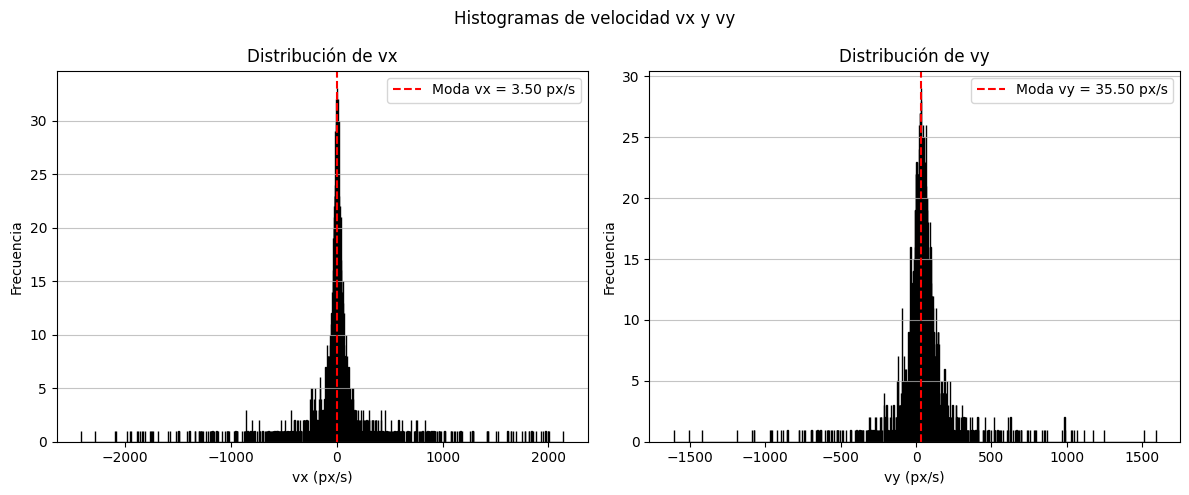

In [20]:
import json
import matplotlib.pyplot as plt
import math
import numpy as np

def cargar_datos_json(ruta_json):
    """
    Carga el archivo JSON y lo devuelve como un diccionario de Python.
    """
    with open(ruta_json, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def graficar_histogramas_vx_vy(data, fps=200):
    """
    Calcula todas las velocidades vx y vy entre pares consecutivos de centroides
    y genera dos histogramas (subplots):
      - Izquierda: histograma de vx
      - Derecha:   histograma de vy
    En ambos casos, se destaca el bin más frecuente ("moda") con una línea vertical
    y se muestra en la leyenda.
    """

    dt = 1/fps
    vx_list = []
    vy_list = []

    # 1) Recolectar todas las velocidades vx y vy
    for fiber_id, fiber_data in data.items():
        if not isinstance(fiber_data, dict):
            continue

        centroides = fiber_data.get("centroide", [])
        if len(centroides) < 2:
            continue

        for i in range(len(centroides) - 1):
            x1, y1 = centroides[i]
            x2, y2 = centroides[i+1]

            vx = (x2 - x1) / dt
            vy = (y2 - y1) / dt

            vx_list.append(vx)
            vy_list.append(vy)

    # Verificamos que existan datos
    if not vx_list or not vy_list:
        print("No se encontraron velocidades para graficar.")
        return

    # 2) Definir bins para vx
    ancho_bin = 1  # Ajusta a tu criterio
    vx_min, vx_max = min(vx_list), max(vx_list)
    vx_range_min = ancho_bin * (int(vx_min // ancho_bin))
    vx_range_max = ancho_bin * (int(vx_max // ancho_bin) + 1)
    bins_vx = np.arange(vx_range_min, vx_range_max + ancho_bin, ancho_bin)

    # 3) Definir bins para vy
    vy_min, vy_max = min(vy_list), max(vy_list)
    vy_range_min = ancho_bin * (int(vy_min // ancho_bin))
    vy_range_max = ancho_bin * (int(vy_max // ancho_bin) + 1)
    bins_vy = np.arange(vy_range_min, vy_range_max + ancho_bin, ancho_bin)

    # 4) Crear subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Histogramas de velocidad vx y vy")

    # --- Hist vx ---
    ax_vx = axs[0]
    n_vx, bins_edges_vx, _ = ax_vx.hist(vx_list, bins=bins_vx,
                                       color='skyblue', edgecolor='black')
    ax_vx.set_title("Distribución de vx")
    ax_vx.set_xlabel("vx (px/s)")
    ax_vx.set_ylabel("Frecuencia")
    ax_vx.grid(axis='y', alpha=0.75)

    # Encontrar la moda
    idx_moda_vx = np.argmax(n_vx)
    bin_left_vx = bins_edges_vx[idx_moda_vx]
    bin_right_vx = bins_edges_vx[idx_moda_vx + 1]
    bin_centro_vx = 0.5 * (bin_left_vx + bin_right_vx)

    # Trazar la línea vertical con la etiqueta en la leyenda
    label_mode_vx = f"Moda vx = {bin_centro_vx:.2f} px/s"
    ax_vx.axvline(x=bin_centro_vx, color='red', linestyle='--', label=label_mode_vx)
    ax_vx.legend()

    # --- Hist vy ---
    ax_vy = axs[1]
    n_vy, bins_edges_vy, _ = ax_vy.hist(vy_list, bins=bins_vy,
                                       color='lightgreen', edgecolor='black')
    ax_vy.set_title("Distribución de vy")
    ax_vy.set_xlabel("vy (px/s)")
    ax_vy.set_ylabel("Frecuencia")
    ax_vy.grid(axis='y', alpha=0.75)

    idx_moda_vy = np.argmax(n_vy)
    bin_left_vy = bins_edges_vy[idx_moda_vy]
    bin_right_vy = bins_edges_vy[idx_moda_vy + 1]
    bin_centro_vy = 0.5 * (bin_left_vy + bin_right_vy)

    label_mode_vy = f"Moda vy = {bin_centro_vy:.2f} px/s"
    ax_vy.axvline(x=bin_centro_vy, color='red', linestyle='--', label=label_mode_vy)
    ax_vy.legend()

    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# EJEMPLO DE USO
# -------------------------------------------------
if __name__ == "__main__":
    # Cambia esta ruta y fps a tu conveniencia
    ruta_json = archivo_fibras_filtrado

    data = cargar_datos_json(ruta_json)
    graficar_histogramas_vx_vy(data, fps=fps)


In [ ]:
#Ahora vuelvo a ejecutar el PTV desde 0, pero, generando zonas de busqueda adaptativas
